## 3.1 Create a Jupyter Notebook and Initialize Variables

In [1]:
from sagemaker import get_execution_role

# retrieve the name of the IAM role that the notebook is running under
role = get_execution_role()
bucket = 'rh-sagemaker-20181024'

print("role: {}".format(role))
print("bucket: {}".format(bucket))

role: arn:aws:iam::191216456264:role/service-role/AmazonSageMaker-ExecutionRole-20181030T052942
bucket: rh-sagemaker-20181024


## 3.2 Download, Explore, and Transform the Training Data

* Download MNIST dataset
* Transform from `numpy.array` to `RecordIO` format
    * [RecordIO Data Format](http://mxnet.incubator.apache.org/architecture/note_data_loading.html#data-format)

### 3.2.1 Download MNIST Dataset

In [2]:
import pickle, gzip, numpy, urllib.request, json

# download the dataset to the notebook's local storage
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")

# deserialize the contents into train, validation, and test sets
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

### 3.2.2 Explore the Training Dataset

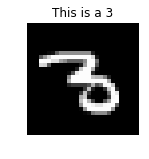

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (2,10)

def show_digit(img, caption='', subplot=None):
    if subplot == None:
        _, (subplot) = plt.subplots(1,1)
    imgr = img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

### 3.2.3 Transform the Training Dataset and Upload to S3

* transform from numpy.array to RecordIO protobuf format
* more efficient for the algorithms provided by SageMaker
* (using high-level SageMaker Python libraries, this happens implicitly)

## 3.3 Train a Model

* Call `CreateTrainingJob`, providing
  * training image ECR path
  * training data S3 path
  * resources configuration to use

### 3.3.1 Choose the Training Algorithm

### 3.3.2 Create a Training Job

* high-level Python api
    * create instance of training algorithm
    * call `fit` method, passing configuration details
    
    
* role: name of the IAM role under which SageMaker runs while performing training
* output_path: S3 location for storing generated output artifacts
* train_instance_count: # of instances to use for training
* train_instance_type: type of instances to use for training
* k: the number of clusters to create
* data_location: location of training data

In [8]:
def build_s3_uri(bucket, key):
    return 's3://{}/{}'.format(bucket, key)

def build_datetime_filename(root):
    return '{}{}'.format(root, strftime("%Y-%m-%d-%H-%M-%S", gmtime()))

In [7]:
%%time

from sagemaker import KMeans

data_location = build_s3_uri(bucket, 'kmeans_highlevel_example/data')
output_location = build_s3_uri(bucket, 'kmeans_highlevel_example/output')

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role, train_instance_count=2,
                train_instance_type='ml.c4.8xlarge',
                output_path=output_location,
                k=10,data_location=data_location)

kmeans.fit(kmeans.record_set(train_set[0]))

training data will be uploaded to: s3://rh-sagemaker-20181024/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://rh-sagemaker-20181024/kmeans_highlevel_example/output


INFO:sagemaker:Creating training-job with name: kmeans-2018-10-31-11-04-30-033


2018-10-31 11:04:30 Starting - Starting the training job...
2018-10-31 11:04:31 Starting - Launching requested ML instances.........
2018-10-31 11:06:10 Starting - Preparing the instances for training......
2018-10-31 11:07:27 Downloading - Downloading input data
2018-10-31 11:07:27 Training - Training image download completed. Training in progress.
Docker entrypoint called with argument(s): train
[10/31/2018 11:07:22 INFO 140077894960960] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'm


2018-10-31 11:07:39 Uploading - Uploading generated training model
2018-10-31 11:07:39 Completed - Training job completed
Billable seconds: 59
CPU times: user 8.23 s, sys: 427 ms, total: 8.65 s
Wall time: 3min 52s


## 3.4 Deploy the Model to Amazon SageMaker

2 Options

* Persistent endpoint to provide one prediction at a time
* Use batch transform to generate predictions for an entire data set

### 3.4.1 Deploy the Model to Amazon SageMaker Hosting Services

3 Steps

1. Create a model in SageMaker
1. Create an endpoint configuration
1. Create an endpoint

The high level api performs all of these via a call to the `deploy` method.

In [6]:
# ## if needed, reload the previously trained model
# from sagemaker import KMeansModel
# model_data = "s3://rh-sagemaker-20181024/kmeans_highlevel_example/output/kmeans-2018-10-30-11-08-55-639/output/model.tar.gz"

# kmeans = KMeansModel(model_data=model_data, role=role)

In [9]:
%%time

## high level api
kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: kmeans-2018-10-31-11-09-09-163
INFO:sagemaker:Creating endpoint with name kmeans-2018-10-31-11-04-30-033


--------------------------------------------------------------!CPU times: user 275 ms, sys: 9.02 ms, total: 284 ms
Wall time: 5min 14s


### 3.4.2 Deploy the Model to Amazon SageMaker Batch Transform

* via console, OR
* high level api, OR
* low level api

In [17]:
## high level api:

import boto3
import sagemaker
import json

input_key = 'kmeans_batch_example/input/valid-data.csv'
input_location = build_s3_uri(bucket, input_key)
output_location = build_s3_uri(bucket, 'kmeans_batch_example/output')
model_name = 'kmeans-2018-10-31-11-09-09-163'

# convert validation set numpy array to CSV and upload to S3
numpy.savetxt('valid-data.csv', valid_set[0], delimiter=',', fmt='%g')
s3_client = boto3.client('s3')
s3_client.upload_file('valid-data.csv', bucket, input_key)

# initialize the transformer object
transformer = sagemaker.transformer.Transformer(
    base_transform_job_name='Batch-Transform',
    model_name=model_name,
    instance_count=1,
    instance_type='ml.c4.xlarge',
    output_path=output_location
)

# start a transform job
transformer.transform(input_location, content_type='text/csv', split_type='Line')

# wait for the job to complete
transformer.wait()

# fetch the validation result
s3_client.download_file(bucket, 'kmeans_batch_example/output/valid-data.csv.out', 'valid-result')

with open('valid-result') as f:
    results = f.readlines()
    
print("Sample transform result: {}".format(results[0]))

INFO:sagemaker:Creating transform job with name: Batch-Transform-2018-10-31-11-36-18-754


.........................................!
Sample transform result: {"closest_cluster":0.0,"distance_to_cluster":6.171431064605713}



## 3.5 Validate the Model

In [13]:
# get a single prediction result
result = kmeans_predictor.predict(valid_set[0][30:31])
print(result)

[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 3.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 5.467881679534912
    }
  }
}
]





Cluster 0:


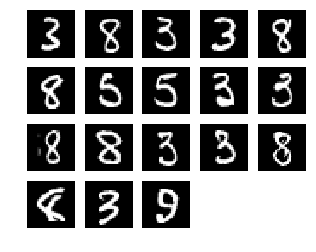




Cluster 1:


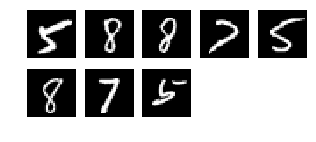




Cluster 2:


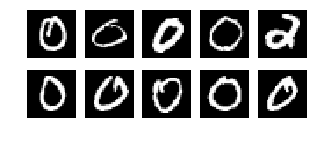




Cluster 3:


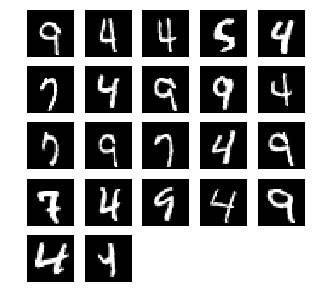




Cluster 4:


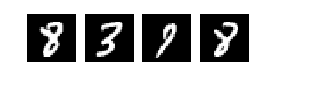




Cluster 5:


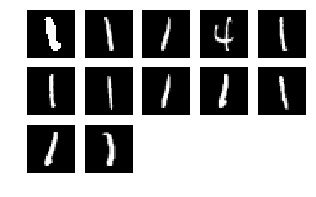




Cluster 6:


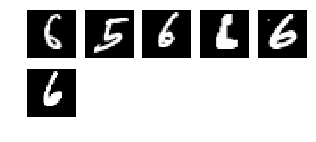




Cluster 7:


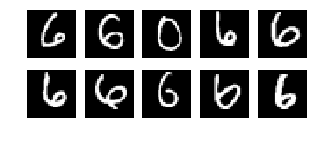




Cluster 8:


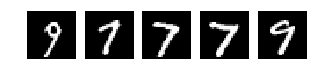




Cluster 9:


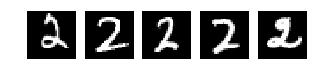

CPU times: user 3.8 s, sys: 1.59 s, total: 5.38 s
Wall time: 3.44 s


In [12]:
%%time 
# do the same for the first 100 images

result = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

for cluster in range(10):
    print('\n\n\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster ]
    height = ((len(digits)-1)//5) + 1
    width = 5
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots = numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')
    plt.show()

In [18]:
# cleanup
kmeans_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint with name: kmeans-2018-10-31-11-04-30-033


## Bare Minimum Steps

In [ ]:
from sagemaker import get_execution_role
from sagemaker import KMeans

train_set, valid_set = load_data()  # load data form _somewhere_
base_path = 's3://rh-sagemaker-20181024/kmeans_highlevel_example',

# train the model
kmeans = KMeans(role=get_execution_role(), 
                data_location=base_path + '/data',
                output_path=base_path + '/output',
                train_instance_count=2,
                train_instance_type='ml.c4.8xlarge',
                k=10)

kmeans.fit(kmeans.record_set(train_set[0]))

# deploy the model
kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

# get a single prediction result
result = kmeans_predictor.predict(valid_set[0][30:31])
print(result)

# cleanup
kmeans_predictor.delete_endpoint()